### XGBoost

In [17]:
# lets import all the dependencies
import warnings 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
import pandas as pd
import numpy as np

import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.model_selection import validation_curve

import xgboost as xgb

from sklearn.metrics import mean_absolute_error, r2_score

In [18]:
# loading the data
df = pd.read_csv("./Data/data.csv",sep=",")
df.drop(['Unnamed: 0'], axis=1, inplace=True) # There were some formatting issues while
                                              # writing the csv

In [19]:
df.head()

,DISTRICT,UPAZILA,STATION_ID,STATION_NAME,DATE,RAIN_FALL(mm),LATITUDE,LONGITUDE,WATER_LEVEL(m)
0,Bandarban,Lama,CL317,Lama,01-jan-2017,0.0,21.81,92.19,6.22
1,Bandarban,Lama,CL317,Lama,02-jan-2017,0.0,21.81,92.19,6.22
2,Bandarban,Lama,CL317,Lama,03-jan-2017,0.0,21.81,92.19,6.22
3,Bandarban,Lama,CL317,Lama,04-jan-2017,0.0,21.81,92.19,6.21
4,Bandarban,Lama,CL317,Lama,05-jan-2017,0.0,21.81,92.19,6.21


Defining our X and y

In [20]:
X = df['RAIN_FALL(mm)'].values.reshape(-1,1) # input feature
y = df['WATER_LEVEL(m)'].values.reshape(-1,1) # target feature

In [21]:
X.shape, y.shape

((1826, 1), (1826, 1))

Making the train test split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.2, random_state=17, shuffle=True
)

#### Model Building

Initialize the CV

In [23]:
kfold = KFold(n_splits=5, shuffle=True, random_state=17)

Initialize the XGB with default parameters!

The values of default parameters can be found here: https://xgboost.readthedocs.io/en/stable/parameter.html

Im using Xgboost sklearn wrapper here so that code structure doesnt change much!

In [24]:
xgb_model = xgb.XGBRegressor()

As usual check the CV score first

In [25]:
results = cross_val_score(
    xgb_model,
    X_train,
    y_train,
    cv=kfold,
    scoring='neg_mean_absolute_error'
)
-results.mean()

0.46924084368144003

checking for train-test accuracy

In [26]:
xgb_model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=6,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [27]:
# accuracy on the train set
knn_pred = xgb_model.predict(X_train)
mean_absolute_error(y_train,knn_pred)

0.35532010421230364

In [28]:
# accuracy on the test set
knn_pred = xgb_model.predict(X_test)
mean_absolute_error(y_test,knn_pred)

0.4707051377530957

Note:
- seems like theres significant overfitting happening here
- Lets plot the learning curve first

#### Learning Curve

In [29]:
# Helper function
alphas = np.logspace(-2, 0, 20)
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, "-", **kwargs)
    plt.fill_between(
        x,
        mu - std,
        mu + std,
        edgecolor="none",
        facecolor=lines[0].get_color(),
        alpha=0.2,
    )

In [30]:
def plot_learning_curve():
    train_sizes = np.linspace(0.05,1,20)
    N_train, val_train, val_test = learning_curve(
        xgb_model,X,y, train_sizes=train_sizes,cv=kfold,scoring='neg_mean_absolute_error'
    )
    plot_with_err(N_train, val_train, label="training scores")
    plot_with_err(N_train, val_test, label="validation scores")
    plt.xlabel("Training Set Size")
    plt.ylabel("Negative MAE")
    plt.legend()
    plt.grid(True);

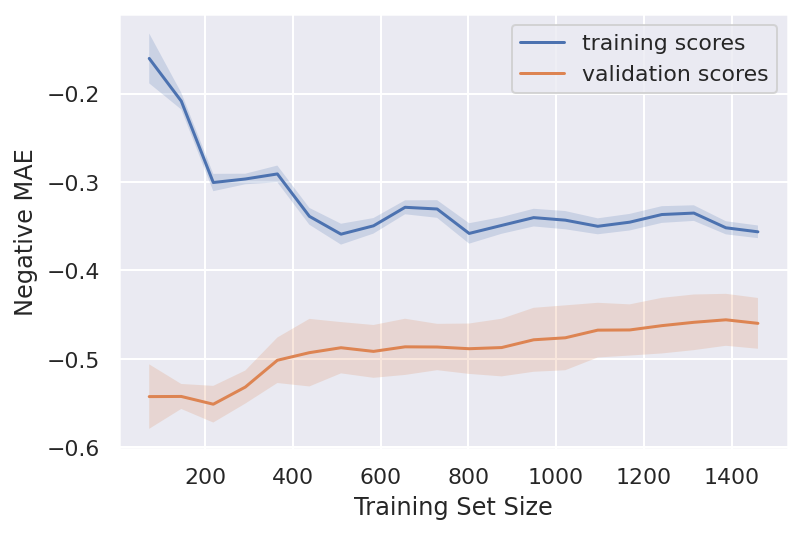

In [31]:
plot_learning_curve()

Note:
- two curves havent converged yet! So theres rooms for improvement!

In [32]:
xgb_model.get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=6,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)>

#### Validation Curves

In [33]:
# helper function
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, "-", **kwargs)
    plt.fill_between(
        x,
        mu - std,
        mu + std,
        edgecolor="none",
        facecolor=lines[0].get_color(),
        alpha=0.2,
    )

In [34]:
def plot_validation_curve(param_grid,param,estimator):
    val_train, val_test = validation_curve(
    estimator=estimator,
    X=X_train,
    y=y_train,
    param_name=param,
    param_range=param_grid,
    cv=kfold,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
    )

    plot_with_err(param_grid, val_train, label="training scores")
    plot_with_err(param_grid, val_test, label="validation scores")
    plt.xlabel(param)
    plt.ylabel("Negative MAE")
    plt.legend()
    plt.grid(True);

- **max_depth:**

/home/salekeen/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/salekeen/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/salekeen/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/salekeen/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use panda

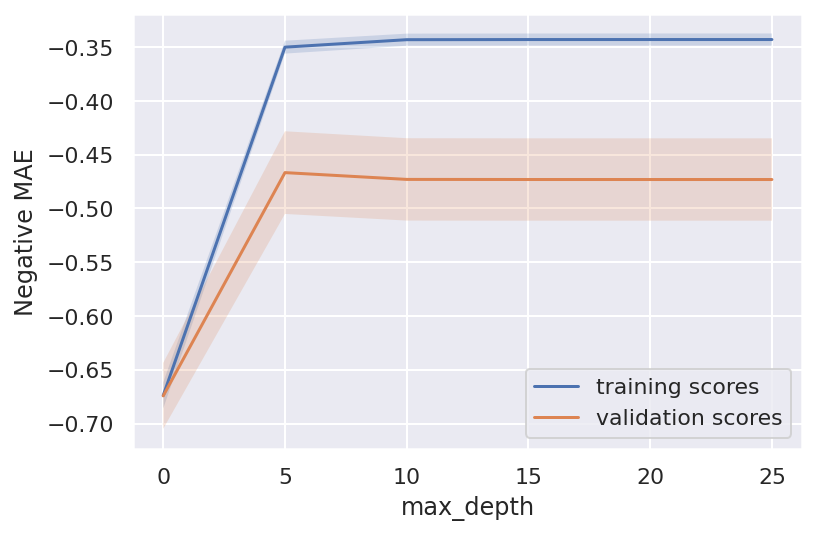

In [35]:
plot_validation_curve(np.arange(0,30,5),'max_depth',xgb_model)

- **gamma:**

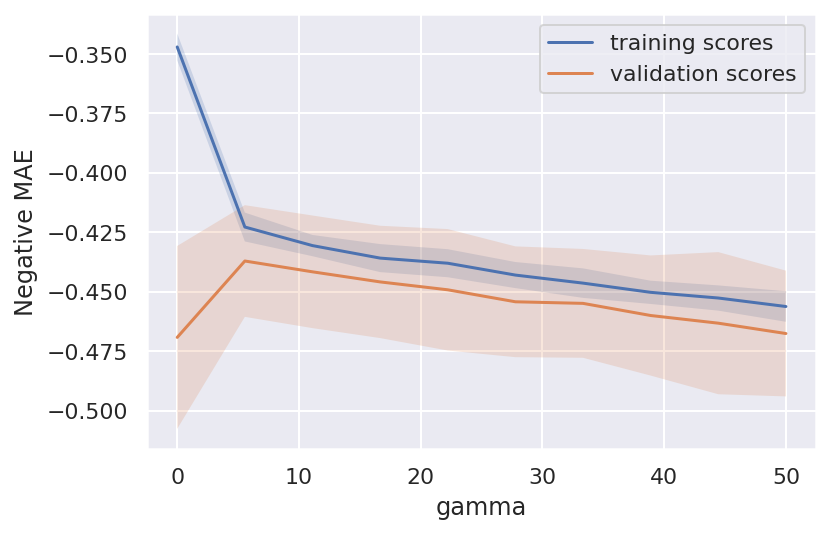

In [36]:
plot_validation_curve(np.linspace(0,50,10),'gamma',xgb_model)

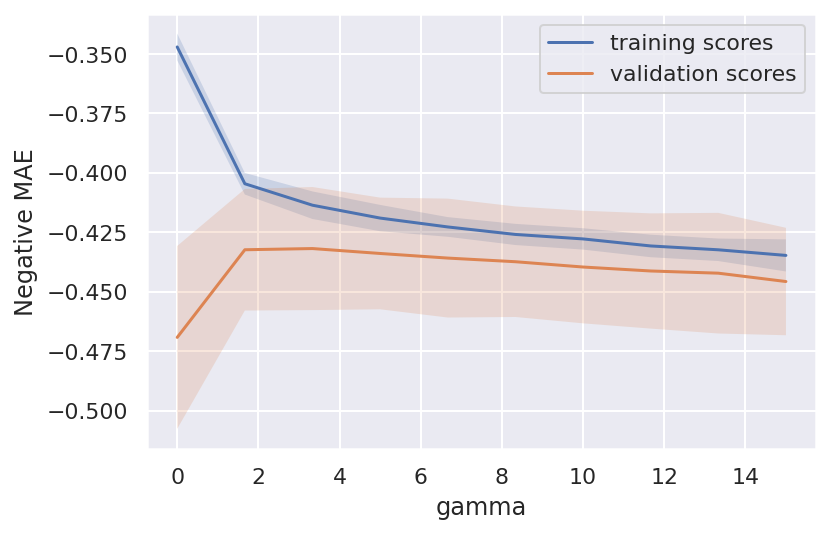

In [37]:
plot_validation_curve(np.linspace(0,15,10),'gamma',xgb_model)

- **min_child_weight:**

In [38]:
xgb_model = xgb.XGBRegressor(gamma = 10)

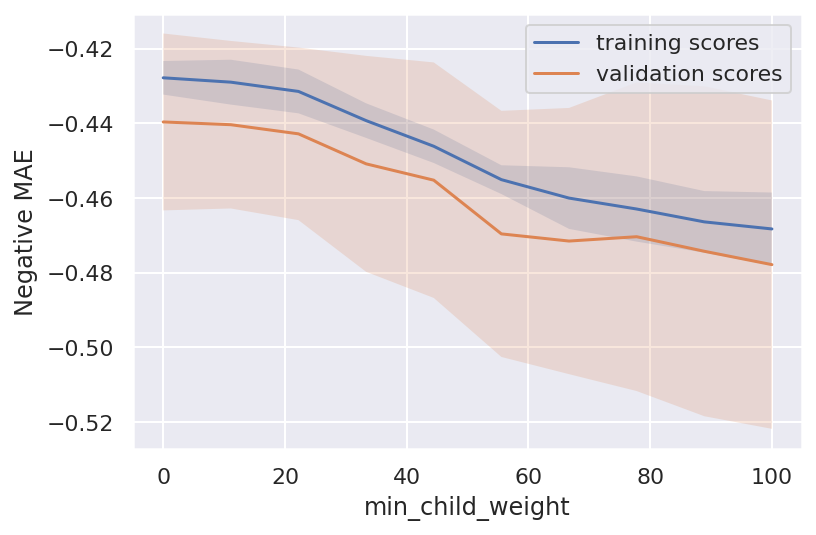

In [39]:
plot_validation_curve(np.linspace(0,100,10),'min_child_weight',xgb_model)

- **subsample:**

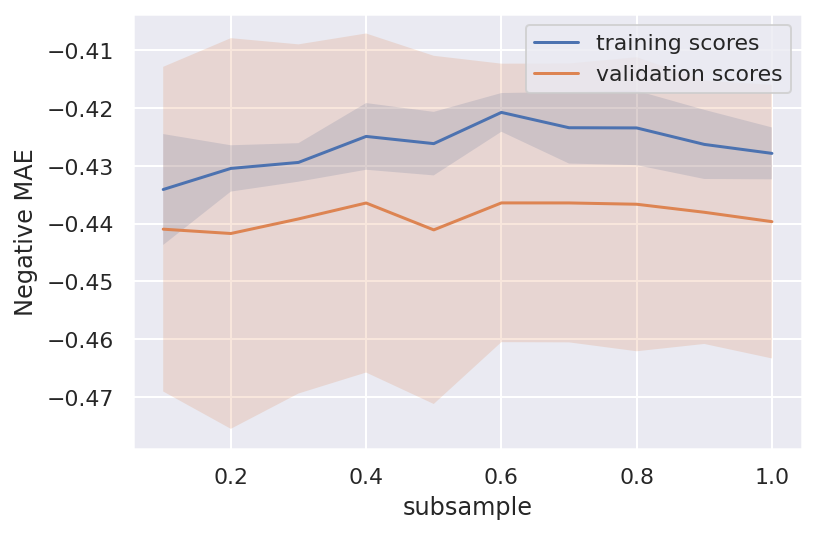

In [40]:
plot_validation_curve([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],'subsample',xgb_model)

#### HyperParameter Tunings

In [41]:
xgbGrid = {
    'max_depth':[5],
    'gamma':[4,5,6],
    'min_child_weight': [0,1],
    'subsample':[0.1,0.2]
}

xgb_model = xgb.XGBRegressor()
gcv = GridSearchCV(xgb_model,xgbGrid,n_jobs=-1,cv=kfold,verbose=1,\
    scoring='neg_mean_absolute_error')

In [42]:
gcv.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=17, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight...
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    sub

In [43]:
gcv.best_score_

-0.4359201454580647

In [44]:
gcv.best_params_

{'gamma': 4, 'max_depth': 5, 'min_child_weight': 0, 'subsample': 0.2}

In [45]:
# accuracy on train set
pred = gcv.best_estimator_.predict(X_train)
mean_absolute_error(y_train,pred)

0.4100284295487077

In [46]:
# accuracy on the test set
pred = gcv.best_estimator_.predict(X_test)
mean_absolute_error(y_test,pred)

0.43212858450217323

#### Result Dataframe

In [51]:
result_df = pd.DataFrame()
result_df['Actual River Level(m)'] = pd.Series(y_test.ravel())
result_df['Predicted'] = gcv.best_estimator_.predict(pd.Series(X_test.ravel()))

In [57]:
result_df.head(50)

,Actual River Level(m),Predicted
0,6.020,6.386051
1,6.230,6.386051
2,6.090,6.386051
3,6.210,6.386051
4,6.190,6.386051
5,5.950,6.386051
6,9.772,7.647743
7,6.270,6.386051
8,7.268,7.220532
9,6.180,6.386051
